# Artificial Neural Network


## 1. Data Preprocessing

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


### 1.1 Importing the dataset

In [0]:
#for some reasons, the data file on github has some problems when reading
#datafile = 'https://github.com/jchen8000/MachineLearning/blob/master/Classification/data/Churn_Modelling.csv'

#Found the same data file from internet
datafile = 'https://floobits.com/calvinlow18/ANN/raw/Churn_Modelling.csv'
dataset = pd.read_csv(datafile)


In [3]:
dataset.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [0]:
X = dataset.iloc[:, 3:13].values
y = dataset.iloc[:, 13].values

#y shape looks like (m,), make it looks like (m,1)
y = y[:,np.newaxis]                


### 1.2 Encoding categorical data

Encode the country name (string) to 0, 1, 2 etc. 
Encode female/male (string) to 0, 1

Also need One Hot Encoding, see [Label Encoder vs. One Hot Encoder](https://medium.com/@contactsunny/label-encoder-vs-one-hot-encoder-in-machine-learning-3fc273365621)

In [0]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
labelencoder_X_1 = LabelEncoder()
X[:, 1] = labelencoder_X_1.fit_transform(X[:, 1])
labelencoder_X_2 = LabelEncoder()
X[:, 2] = labelencoder_X_2.fit_transform(X[:, 2])



In [6]:
onehotencoder = OneHotEncoder(categorical_features = [1])
X = onehotencoder.fit_transform(X).toarray()
X = X[:, 1:]

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:390: DeprecationWarning: The 'categorical_features' keyword is deprecated in version 0.20 and will be removed in 0.22. You can use the ColumnTransformer instead.
  "use the ColumnTransformer instead.", DeprecationWarning)


### 1.3 Splitting the dataset into the Training set and Test set


In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

### 1.4 Feature Scaling

In [0]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


In [9]:
print( X_train.shape )
print( X_test.shape )
print( y_train.shape )
print( y_test.shape )

(8000, 11)
(2000, 11)
(8000, 1)
(2000, 1)


## 2. Build a Neural Network from scratch

![Neural Network Model](https://cdn-images-1.medium.com/max/800/1*l78dvvJFf0cOJnXTJglR7A.png)

### 2.1 Neural Network Cost Function

> ## $ \min_\Theta J(\Theta)=-\frac{\mathrm{1} }{m} \sum_{i=1}^{m}  \sum_{k=1}^{K}\left[ y_k^{(i)} log((h_\Theta(x^{(i)}))_k) + (1 - y_k^{(i)}) log (1 - (h_\Theta(x^{(i)}))_k) \right]  + \frac{\mathrm{\lambda}}{2m}  \sum_{l=1}^{L-1} \sum_{i=1}^{S_l}\sum_{j=1}^{S_l+1}( \Theta_{ji}^{(l)})^2$

> Where $ h_\Theta(x)  \in  \mathbb{R}^K, (h_\Theta(x))_i = i^{th} output  $

> $ L = $ total no. of layers in neural network

> $ S_l = $ no. of units (not couning bias unit ) in layer $ l $

> ### Think of $ J(\Theta) \approx ( h_\Theta(x^{(i)}) - y^{(i)} ) ^2 $

### 2.2 Sigmoid Gredient

> ## $\frac{\mathrm{d} }{\mathrm{d} z}g(z) = g(z)(1-g(z)) $

> where

> ## $ g(z) = sigmoid(z) = \frac{\mathrm{1} }{\mathrm{1} + e^{-z} }  $






### 2.3 Backpropagation

> ## $  \delta^{(3)}_j = a_j^{(3)} - y_j $,  ( total number of layers $ L = 3 $ )

> ## $  \delta^{(2)} = ( \Theta^{(2)} )^T  \delta^{(3)} .* g'(z^{(2)}) $

> ## $  \delta^{(1)} = ( \Theta^{(1)} )^T  \delta^{(2)} .* g'(z^{(1)}) $

In [0]:
class Neural_Network(object):
  def __init__(self, inputSize, hiddenSize, outputSize, lmbda):
  #parameters
    self.inputSize = inputSize
    self.outputSize = outputSize
    self.hiddenSize = hiddenSize
    self.lmbda = lmbda
    
  #weights
    epsilon = 0.2
    self.theta1 = np.random.randn(self.inputSize, self.hiddenSize)  * 2 * epsilon - epsilon
    self.theta2 = np.random.randn(self.hiddenSize, self.outputSize) * 2 * epsilon - epsilon
    #self.theta1 = np.random.rand(self.inputSize, self.hiddenSize) * 2 * epsilon - epsilon
    #self.theta2 = np.random.rand(self.hiddenSize, self.outputSize) * 2 * epsilon - epsilon
    
  #history
    self.loss_history =  [] 

  def forward(self, X):
    #forward propagation through our network
    self.z = np.dot(X, self.theta1) # dot product of X (input) and first set of 3x2 weights
    self.z2 = self.sigmoid(self.z) # activation function
    self.z3 = np.dot(self.z2, self.theta2) # dot product of hidden layer (z2) and second set of 3x1 weights
    o = self.sigmoid(self.z3) # final activation function
    return o

  def sigmoid(self, s):
    # activation function
    return 1/(1+np.exp(-s))

  def sigmoidPrime(self, s):
    #derivative of sigmoid
    return s * (1 - s)

  def backward(self, X, y, o):
    # backward propagate through the network
    self.o_error = y - o # error in output
    self.o_delta = self.o_error*self.sigmoidPrime(o) # applying derivative of sigmoid to error

    self.z2_error = self.o_delta.dot(self.theta2.T) # z2 error: how much our hidden layer weights contributed to output error
    self.z2_delta = self.z2_error*self.sigmoidPrime(self.z2) # applying derivative of sigmoid to z2 error

    self.theta1 += X.T.dot(self.z2_delta) # adjusting first set (input --> hidden) weights
    self.theta2 += self.z2.T.dot(self.o_delta) # adjusting second set (hidden --> output) weights
    
  def cost(self, X, y ):
    m = len(y)
    y_output = self.forward(X)
    
    c1 = np.multiply(y, np.log(y_output))
    c2 = np.multiply(1-y, np.log(1-y_output))
    c = np.sum(c1 + c2)
    
    r1 = np.sum(np.sum(np.power(self.theta1,2), axis = 1))
    r2 = np.sum(np.sum(np.power(self.theta2,2), axis = 1))
    
    return np.sum(c / (-m)) + (r1 + r2) * self.lmbda / (2*m)

  
  def loss(self, X, y):
    return np.mean(np.square(y - self.forward(X)))

  def train(self, X, y, epoch):
    for i in range(epoch):
      o = self.forward(X)
      self.backward(X, y, o)
      self.loss_history.append(self.loss(X,y))
      print("epoch:[", i, "], loss: ", str(self.loss(X,y))  )

  def predict(self, X):
    return self.forward(X)
  
  
  def get_loss_histroy(self):
    return self.loss_history

  def get_weight(self):
    return self.theta1, self.theta2


In [0]:
#Plot the convergence of the cost function
def plotConvergence(cost_history, iterations):
    plt.figure(figsize=(10,6))
    plt.plot(range(len(cost_history)),cost_history,'bo')
    plt.grid(True)
    plt.title("Convergence of Cost Function")
    plt.xlabel("Iteration number")
    plt.ylabel("Cost function")
    dummy = plt.xlim([-0.05*iterations,1.05*iterations])
    dummy = plt.ylim([min(cost_history)-0.2*(max(cost_history)-min(cost_history)), max(cost_history)+0.2*(max(cost_history)-min(cost_history))])


In [0]:
NN = Neural_Network( 11, 6, 1, 1 )
#t1, t2 = NN.get_weight()
iterations = 500
NN.train(X_train, y_train, iterations)


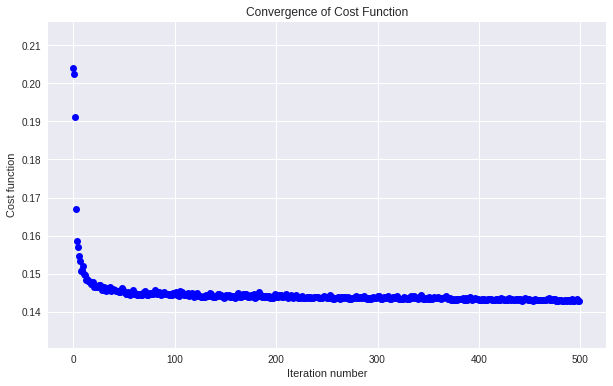

In [19]:
plotConvergence(NN.get_loss_histroy(),iterations )

In [20]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

y_pred = NN.predict(X_test)
y_pred = (y_pred >= 0.5)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nAccuracy Score:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Confusion Matrix:
 [[1575   20]
 [ 342   63]]

Accuracy Score: 0.819

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.99      0.90      1595
           1       0.76      0.16      0.26       405

   micro avg       0.82      0.82      0.82      2000
   macro avg       0.79      0.57      0.58      2000
weighted avg       0.81      0.82      0.77      2000

